In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator # for minor ticks
from matplotlib import gridspec

import numpy as np

from scipy import signal # for convolution
import scipy.stats as stats
import scipy.special as sps

from itertools import product

import sys
sys.path.append("../..")

from neuroprob.utils import stats, tools, neural_utils
import neuroprob.models as mdl

dev = tools.PyTorch()

PyTorch version: 1.6.0
Using device: cpu


In [67]:
%matplotlib inline

This notebook contains code for:
- Toy model of 1D phase precession to generate synthetic data
- Performing the 'Huxter' test for independent rate and temporal coding
- Brown paper no coupling, Huxter test
- Brown paper with coupling, Huxter test

**When saving figures, first navigate to the appropriate folder**

In [104]:
import os

In [111]:
os.getcwd()

'C:\\Users\\Mattijs\\Documents\\Mattijs\\Engineering IIB\\Thesis'

In [110]:
os.chdir('..')

### Synthetic one-dimensional phase precession model
Chadwick, Angus, Mark CW van Rossum, and Matthew F. Nolan `Independent theta phase coding accounts for CA1 population sequences and enables flexible remapping.` Elife 4 (2015): e03542.

\begin{align}
r_x(x) &= r_0\exp\Big(\frac{(x-c)}{2\sigma^2}\Big)  \\
r_\theta(\theta(t), \theta_0(x)) &= \exp\big(\beta \cos(\theta(t) - \theta_0(x))\big)\\
\theta_0(x) &= 2\pi\Big(1-\frac{(x-c+R)}{2R}\Big) - \pi\\
\end{align}

<strong>Extension:</strong> Use 2D form, see appendix A6

In [2]:
# phase precession model
def gen_field_gaussian(x, theta, cen, sigma):
    # Requires theta -pi, +pi
    c = np.array([cen])
    rate_0 = 10 # per ms
    rate = rate_0*np.exp(-0.5*((x-c)/sigma)**2)
    return rate


def gen_field_brown(x, theta, cen, sigma):
    # Requires theta -pi, +pi
    beta = 1.0
    c = np.array([cen])
    rate_0 = 10 # per ms
    R = 2*sigma
    rate = rate_0*np.exp(-0.5*((x-c)/sigma)**2) * np.exp(beta*np.cos(theta - 0))
    return rate


def gen_field_chadwick(x, theta, cen, sigma):
    # Requires theta -pi, +pi
    beta = 1.0
    c = np.array([cen])
    rate_0 = 10 # per ms
    R = 2*sigma
    theta_0 = 2*np.pi * (1 - (np.clip(x, c-R, c+R)-c+R)/2/R) - np.pi
    rate = rate_0*np.exp(-0.5*((x-c)/sigma)**2) * np.exp(beta*np.cos(theta - theta_0))
    return rate


def gen_theta_t(theta_period, theta_offset, dt, sim_samples):
    theta_t = np.zeros(sim_samples)
    theta_t.fill(2*np.pi / (theta_period/dt)) # radians
    theta_t = np.cumsum(theta_t) + theta_offset
    theta_t = theta_t % (2*np.pi) - np.pi # -pi to +pi
    
    return theta_t

#### Example place field

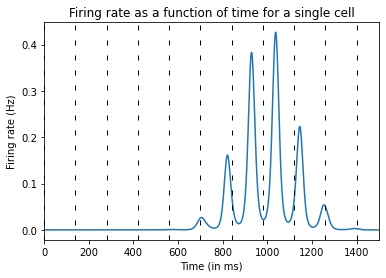

In [8]:
# plot the firing rate
theta_period = 140
dx, dt = 0.06, 1.5
sim_samples = 1000
centre = 40
sigma = 5
dx_arr = np.empty(sim_samples)
dx_arr.fill(dx) # ms
x_t = np.cumsum(dx_arr)
t_t = np.arange(0, sim_samples*dt, dt) # ms
theta_wavelength = theta_period * (dx/dt) # mm
theta_t = gen_theta_t(theta_period, theta_offset, dt, sim_samples)
plt.plot(t_t, gen_field(t_t, x_t, theta_t, centre, sigma))
[plt.axvline(theta_tick, ls=(0, (5, 10)), c='k', lw='1') for theta_tick in np.arange(min(t_t), max(t_t)+1, theta_period)]
plt.title("Firing rate as a function of time for a single cell")
plt.xlim(0, 1500)
plt.xlabel("Time (in ms)")
plt.ylabel("Firing rate (Hz)")
plt.show()

### Plotting place fields

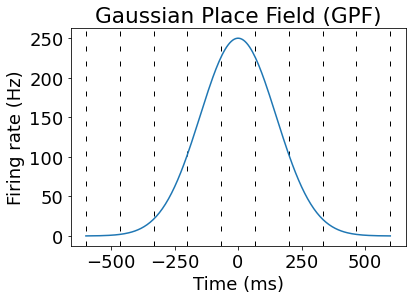

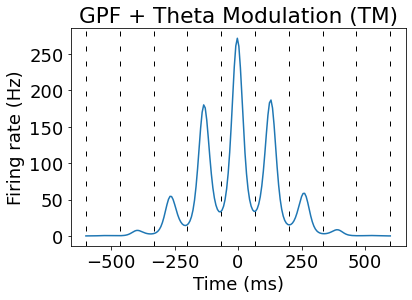

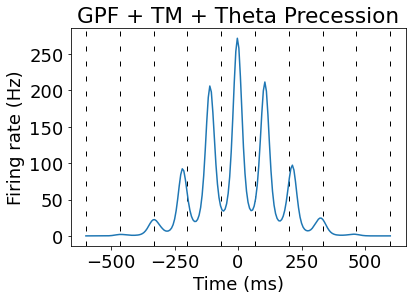

In [71]:
x_t = np.linspace(-600, 600, 200)
dt = (abs(min(x_t)) + abs(max(x_t))) / 200
rate_0 = 100
rate_0_g = 250
theta_0 = 0
c = 0
sigma = 150
R = 2*sigma
beta = 1.0
theta_period = 133.3

theta_t = np.empty(200) # radians
theta_period = 133.3 # ms
theta_offset = 0.0
theta_t.fill(2*np.pi*dt/theta_period)
theta_t = np.cumsum(theta_t) + theta_offset
theta_t_cumsum = theta_t
theta_t = theta_t % (2*np.pi) - np.pi # -pi to +pi

theta_precess = 2*np.pi * (1 - (np.clip(x_t, c-R, c+R)-c+R)/2/R) - np.pi
 
rate_gaussian = rate_0_g*np.exp(-0.5*((x_t-c)/sigma)**2)

rate_brown = rate_0*np.exp(-0.5*((x_t-c)/sigma)**2) * np.exp(beta*np.cos(theta_t - theta_0))

rate_chadwick = rate_0*np.exp(-0.5*((x_t-c)/sigma)**2) * np.exp(beta*np.cos(theta_t - theta_precess))


[plt.axvline(theta_tick, ls=(0, (5, 10)), c='k', lw='1') for theta_tick in np.arange(min(x_t), max(x_t)+1, theta_period)]
plt.plot(x_t, rate_gaussian)
plt.xlabel("Time (ms)")
plt.ylabel("Firing rate (Hz)")
plt.title("Gaussian Place Field (GPF)")

plt.show()

[plt.axvline(theta_tick, ls=(0, (5, 10)), c='k', lw='1') for theta_tick in np.arange(min(x_t), max(x_t)+1, theta_period)]
plt.plot(x_t, rate_brown)
plt.xlabel("Time (ms)")
plt.ylabel("Firing rate (Hz)")
plt.title("GPF + Theta Modulation (TM)")

plt.show()


[plt.axvline(theta_tick, ls=(0, (5, 10)), c='k', lw='1') for theta_tick in np.arange(min(x_t), max(x_t)+1, theta_period)]
plt.plot(x_t, rate_chadwick)
plt.xlabel("Time (ms)")
plt.ylabel("Firing rate (Hz)")
plt.title("GPF + TM + Theta Precession")

plt.show()

In [79]:
def heatmap_parametric(func_models, x_max, ax_titles=None):
    funcs = []
    ax_title = {}
    
    for cur_func in func_models:
        def func_adj(pos, centre=30, sigma=10):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            theta = pos[1].flatten()
            covariates = [x, theta]
            return cur_func(x, theta, centre, sigma).reshape(*prevshape)
        funcs.append(func_adj)
        ax_title[len(funcs) - 1] = "Function" + str(cur_func)
    
    nrows = 1
    ncols = len(funcs)
    widths = [0.5] * ncols
    heights = [1] * nrows
    
    fig = plt.figure(figsize=(4*ncols, 3*nrows))

    spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                             height_ratios=heights)#, left=0., right=0.2, bottom=0., top=1.)

    neuron = 0
    if ax_titles is not None:
        ax_title = ax_titles
#     x_max = x_ts.max() # mm
        
    for i, func in enumerate(funcs):
    
        grid_shape = [[0, x_max], [0, 4*np.pi]]
        grid_size = [50, 80]

        ax = fig.add_subplot(spec[0, i])
        _, field = tools.compute_mesh(grid_size, grid_shape, func)
        _, ax = tools.visualize_field(field, grid_shape, ticktitle='firing rate (Hz)', figax=(fig, ax), aspect='auto')

        ylabel = r'$\theta$'
        xlabel = r'$x$ (mm)'
        tools.decorate_ax(ax, xlabel=xlabel, ylabel=ylabel, xlim=[0, np.round(x_max)], ylim=[0, 4*np.pi],
                          xticks=[0, np.round(x_max)], yticks=[0, 2*np.pi,  4*np.pi],
                          spines=[False, False, False, False])
        ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])
        ax.set_title(ax_title[i])

    plt.tight_layout(w_pad=1)
    plt.show()
    
    return fig

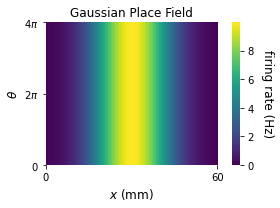

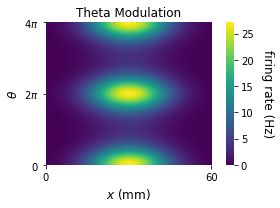

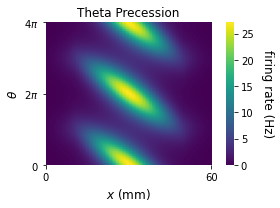

In [80]:
x_max = 60

# ### Gaussian Place Field
fig_theta_mod = heatmap_parametric([gen_field_gaussian], x_max, ax_titles=['Gaussian Place Field'])
fig_theta_mod.savefig('output/place field gaussian.svg', bbox_inches='tight')

### Theta modulation
fig_theta_mod = heatmap_parametric([gen_field_brown], x_max, ax_titles=['Theta Modulation'])
fig_theta_mod.savefig('output/place field theta modulation.svg', bbox_inches='tight')

### Theta precession
fig_theta_mod = heatmap_parametric([gen_field_chadwick], x_max, ax_titles=['Theta Precession'])
fig_theta_mod.savefig('output/place field theta precession.svg', bbox_inches='tight')

### Huxter 'test' for independent rate and temporal coding
John Huxter, Neil Burgess, and John O'Keefe `Independent rate and temporal coding in hippocampal pyramidal cells` Nature (2003): n02058

#### Circular correlation coefficient
\begin{align}
\mathbf{u} &= (\cos\theta, \sin\theta) \\
r_{xc} &= corr(x, cos\,\theta) \\
r_{xs} &= corr(x, sin\,\theta) \\
r_{cs} &= corr(cos \,\theta, sin \,\theta) \\
R^2_{x\theta} &= \frac{r^2_{xc} + r^2_{xs} - 2r_{xc}r_{xs}r_{cs}}{1-r^2_{cs}}
\end{align}

In [130]:
plt.rcParams['font.size'] = 14

In [148]:
def phase_position_plot(x_spike, theta_spike, c_n=None):    
    x = x_spike
    y = theta_spike/np.pi*180
    
    print("Pearson's r: ", np.corrcoef(x, theta_spike))
    lin_cir_r = np.round(stats.corr_lin_circ(x, theta_spike), 3)
    print("Linear circular r: ", stats.corr_lin_circ(x, theta_spike))
#     for i in range(1,6):
#         ind = np.where(cell_number == i)
#         plt.scatter(x[ind], y[ind], s=3)
#         plt.scatter(x[ind], y[ind]+360, s=3)
    plt.scatter(x, y, c='r', s=3)
    plt.scatter(x,y+360, c='r', s=3)
    plt.title("$r=$" + str(lin_cir_r))
    plt.xlabel("Position")
    plt.ylabel("Phase (deg)")
    plt.ylim(-180,540)
    plt.yticks(np.arange(-180, 541, 90))
    plt.xlim(0,60)
    plt.show()


def phase_time_plot(t_infield_spike, theta_spike, c_n=None):    
    x = t_infield_spike
    y = theta_spike/np.pi*180
    
    print("Pearson's r: ", np.corrcoef(x, theta_spike))
    lin_cir_r = np.round(stats.corr_lin_circ(x, theta_spike), 3)
    print("Linear circular r: ", stats.corr_lin_circ(x, theta_spike))
#     for i in range(1, 6):
#         ind = np.where(cell_number == i)
#         plt.scatter(x[ind], y[ind], s=3)
#         plt.scatter(x[ind], y[ind]+360, s=3)
    plt.scatter(x, y, c='r', s=3)
    plt.scatter(x,y+360, c='r', s=3)
    plt.title("$r=$" + str(lin_cir_r))
    plt.xlabel("Time in field")
    plt.ylabel("Phase (deg)")
    plt.ylim(-180,540)
    plt.yticks(np.arange(-180, 541, 90))
    plt.show()
    
def phase_combo_plot(x_spike, t_infield_spike, theta_spike):
    x = x_spike
    t = t_infield_spike
    y = theta_spike/np.pi*180
    
    r_x = np.round(stats.corr_lin_circ(x, theta_spike), 3)
    r_t = np.round(stats.corr_lin_circ(t, theta_spike), 3)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    
    ax[0].scatter(x, y, c='r', s=3)
    ax[0].scatter(x,y+360, c='r', s=3)
    ax[0].set_title("$r=$" + str(r_x))
    ax[0].set_xlabel("Position")
    ax[0].set_ylabel("Phase (deg)")
    ax[0].set_ylim(-180,540)
    ax[0].set_yticks(np.arange(-180, 541, 180))
    ax[0].set_xlim(0,60)
    
    ax[1].scatter(t, y, c='r', s=3)
    ax[1].scatter(t,y+360, c='r', s=3)
    ax[1].set_title("$r=$" + str(r_t))
    ax[1].set_xlabel("Time in field")
    ax[1].set_xlim(-2, 10)
    ax[1].set_ylim(-180,540)
    ax[1].set_yticks(np.arange(-180, 541, 180))
    
    plt.tight_layout()
    plt.show()
    
    return fig
    

def x_theta_t_spike(sep_t_spike, x_ts, t_t, centre=30.0, R=20.0):
    x_spike = []
    theta_spike = []
    t_infield_spike = []
    cell_number = []
    for cell_i, n_t_spike in enumerate(sep_t_spike):
        for spike_t_index, theta in zip(n_t_spike[0], n_t_spike[1]):
            cell_number.append(cell_i)
            x_spike.append(x_ts[cell_i, spike_t_index])
            t_infield_spike.append(t_t[spike_t_index] - t_t[np.min(np.where(x_ts[cell_i] >= (centre-R)))])
            theta_spike.append(theta)

    x_spike = np.array(x_spike)
    theta_spike = np.array(theta_spike)
    t_infield_spike = np.array(t_infield_spike)
    cell_number = np.array(cell_number)
    
    return x_spike, theta_spike, t_infield_spike, cell_number

#### Phase with position and time in field, single cell constant speeds

In [89]:
# Multiple constant speeds, single cell
sim_samples = 4000
dt = 1.5*0.01 # mm
t_t = np.arange(0, sim_samples*dt, dt) # ms

theta_period = 140*0.01 # ms
theta_offset = 0.0
theta_t = gen_theta_t(theta_period, theta_offset, dt, sim_samples)

dxs = np.linspace(0.05, 0.15, 30) # mm

# Gamma renewal process (includes Poisson)
shape = 1.0
renew = mdl.point_process.ISI_gamma(shape)

centre = 30
sep_t_spike = []
x_ts = []
t_spikes = []
for dx in dxs:
    theta_wavelength = theta_period * (dx/dt)
    dx_arr = np.empty(sim_samples)
    dx_arr.fill(dx) # mm
    x_t = np.cumsum(dx_arr)
    x_ts.append(x_t)
    rate = gen_field_chadwick(x_t, theta_t, centre, 10.0)[None, :]
    
#     # Store spike times for this neuron
#     spike_times = mdl.point_process.gen_IRP(renew, rate, dt)[0]
#     sep_t_spike.append([spike_times, theta_t[spike_times]])
    
    # Store spikes, spike times for this neuron
    spikes = mdl.point_process.gen_IPP(rate, dt, max_count=1e5)
    # t_spikes = stats.gen_IRP(renew, rate, dt)  # Now it's all in mdl.pint_process
    for i, r in enumerate(rate):
        spike_times = neural_utils.BinToTrain(spikes[i])
        t_spikes.append([spike_times, theta_t[spike_times]]) # get spike time indices

x_ts = np.array(x_ts)

Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 126
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 126
Dilation exceeded: False
Dilation: 128
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 126
Dilation exceeded: False
Dilation: 124
Dilation exceeded: False
Dilation: 127
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 128
Dilation exceeded: False
Dilation: 125
Dilation exceeded: False
Dilation: 122
Dilation exceeded: False
Dilation: 121
Dilation exceeded: False
Dilation: 124
Dilation exceeded: False
Dilation: 126
Dilation exceeded: False
Dilation: 127
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False


In [90]:
x_spike, theta_spike, t_infield_spike, cell_number = x_theta_t_spike(t_spikes, x_ts, t_t)

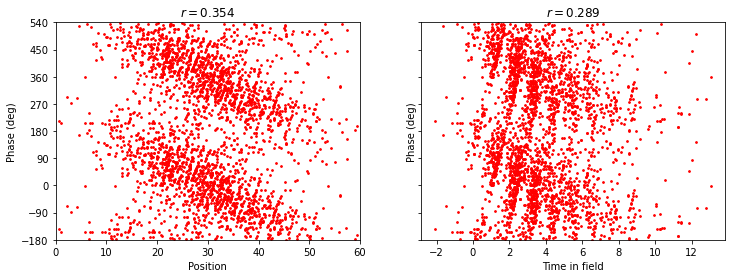

In [112]:
# phase_position_plot(x_spike, theta_spike, cell_number)
# phase_time_plot(t_infield_spike, theta_spike, cell_number)
fig = phase_combo_plot(x_spike, t_infield_spike, theta_spike)
fig.savefig('output/chadwick_correlation.svg', bbox_inches='tight')

In [83]:
# Multiple constant speeds, single cell
sim_samples = 4000
dt = 1.5*0.01 # mm
t_t = np.arange(0, sim_samples*dt, dt) # ms

theta_period = 140*0.01 # ms
theta_offset = 0.0
theta_t = gen_theta_t(theta_period, theta_offset, dt, sim_samples)

dxs = np.linspace(0.05, 0.15, 30) # mm

# Gamma renewal process (includes Poisson)
shape = 1.0
renew = mdl.point_process.ISI_gamma(shape)

centre = 30
sep_t_spike = []
x_ts = []
t_spikes = []
for dx in dxs:
    theta_wavelength = theta_period * (dx/dt)
    dx_arr = np.empty(sim_samples)
    dx_arr.fill(dx) # mm
    x_t = np.cumsum(dx_arr)
    x_ts.append(x_t)
    rate = gen_field_brown(x_t, theta_t, centre, 10.0)[None, :]
    
#     # Store spike times for this neuron
#     spike_times = mdl.point_process.gen_IRP(renew, rate, dt)[0]
#     sep_t_spike.append([spike_times, theta_t[spike_times]])
    
    # Store spikes, spike times for this neuron
    spikes = mdl.point_process.gen_IPP(rate, dt, max_count=1e5)
    # t_spikes = stats.gen_IRP(renew, rate, dt)  # Now it's all in mdl.pint_process
    for i, r in enumerate(rate):
        spike_times = neural_utils.BinToTrain(spikes[i])
        t_spikes.append([spike_times, theta_t[spike_times]]) # get spike time indices

x_ts = np.array(x_ts)

Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 126
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 125
Dilation exceeded: False
Dilation: 127
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 125
Dilation exceeded: False
Dilation: 122
Dilation exceeded: False
Dilation: 126
Dilation exceeded: False
Dilation: 128
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 127
Dilation exceeded: False
Dilation: 123
Dilation exceeded: False
Dilation: 118
Dilation exceeded: False
Dilation: 116
Dilation exceeded: False
Dilation: 120
Dilation exceeded: False
Dilation: 124
Dilation exceeded: False
Dilation: 126
Dilation exceeded: False
Dilation: 128
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False


In [85]:
x_spike, theta_spike, t_infield_spike, cell_number = x_theta_t_spike(t_spikes, x_ts, t_t)

Pearson's r:  [[1.         0.00135807]
 [0.00135807 1.        ]]
Linear circular r:  0.025014884002747262


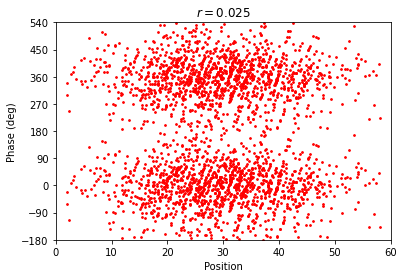

Pearson's r:  [[1.         0.02844023]
 [0.02844023 1.        ]]
Linear circular r:  0.021368033923193235


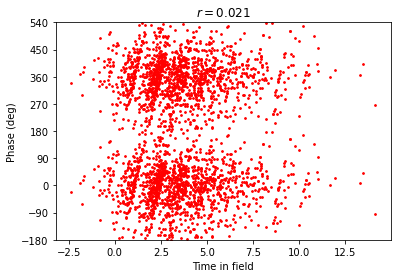

In [86]:
phase_position_plot(x_spike, theta_spike)
phase_time_plot(t_infield_spike, theta_spike)
phase_combo_plot(x_spike, t_infield_spike, theta_spike)

#### Phase with position and time in field, single cell random speeds

In [150]:
# Multiple constant speeds, single cell
sim_samples = 4000
dt = 1.5*0.01 # mm
t_t = np.arange(0, sim_samples*dt, dt) # ms

theta_period = 140*0.01 # ms
theta_offset = 0.0
theta_t = gen_theta_t(theta_period, theta_offset, dt, sim_samples)

dxs = np.linspace(0.05, 0.15, 30) # mm

# Gamma renewal process (includes Poisson)
shape = 1.0
# renew = stats.ISI_gamma(shape)

centre = 30
sigma = 10.0
t_spikes = []
x_ts = []
for dx in dxs:
    theta_wavelength = theta_period * (dx/dt)
    dx_arr = 0.8 * np.random.randn(sim_samples) + dx
    x_t = np.cumsum(dx_arr)
    x_ts.append(x_t)
    rate = gen_field_chadwick(x_t, theta_t, centre, sigma)[None, :] # Adds extra dimension, not sure why?
    
#     # Store spike times for this neuron
#     spike_times = stats.gen_IRP(renew, rate, dt)[0]
#     sep_t_spike.append([spike_times, theta_t[spike_times]])

    # Store spikes, spike times for this neuron
    spikes = mdl.point_process.gen_IPP(rate, dt, max_count=1e5)
    # t_spikes = stats.gen_IRP(renew, rate, dt)  # Now it's all in mdl.pint_process
    for i, r in enumerate(rate):
        spike_times = neural_utils.BinToTrain(spikes[i])
        t_spikes.append([spike_times, theta_t[spike_times]]) # get spike time indices

x_ts = np.array(x_ts)

Dilation exceeded: False
Dilation: 126
Dilation exceeded: False
Dilation: 128
Dilation exceeded: False
Dilation: 120
Dilation exceeded: False
Dilation: 127
Dilation exceeded: False
Dilation: 126
Dilation exceeded: False
Dilation: 124
Dilation exceeded: False
Dilation: 123
Dilation exceeded: False
Dilation: 125
Dilation exceeded: False
Dilation: 128
Dilation exceeded: False
Dilation: 118
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 127
Dilation exceeded: False
Dilation: 125
Dilation exceeded: False
Dilation: 128
Dilation exceeded: False
Dilation: 99
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 121
Dilation exceeded: False
Dilation: 128
Dilation exceeded: False
Dilation: 128
Dilation exceeded: False
Dilation: 128
Dilation exceeded: False
Dilation: 105
Dilation exceeded: False
Dilation: 124
Dilation exceeded: False
Dilation: 117
Dilation exceeded: False
Dilation: 108
Dilation exceeded: False
D

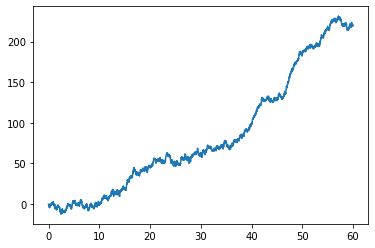

In [118]:
plt.plot(t_t, x_ts[0])

In [151]:
x_spike, theta_spike, t_infield_spike, cell_number = x_theta_t_spike(t_spikes, x_ts, t_t)

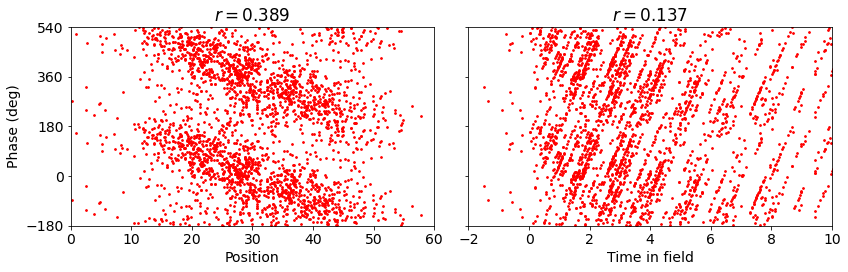

In [152]:
# phase_position_plot(x_spike, theta_spike)
# phase_time_plot(t_infield_spike, theta_spike)
fig = phase_combo_plot(x_spike, t_infield_spike, theta_spike)
fig.savefig('output/chadwick_correlation.svg', bbox_inches='tight')

In [144]:
# Multiple constant speeds, single cell
sim_samples = 4000
dt = 1.5*0.01 # mm
t_t = np.arange(0, sim_samples*dt, dt) # ms

theta_period = 140*0.01 # ms
theta_offset = 0.0
theta_t = gen_theta_t(theta_period, theta_offset, dt, sim_samples)

dxs = np.linspace(0.05, 0.15, 30) # mm

# Gamma renewal process (includes Poisson)
shape = 1.0
# renew = stats.ISI_gamma(shape)

centre = 30
sigma = 10.0
t_spikes = []
x_ts = []
for dx in dxs:
    theta_wavelength = theta_period * (dx/dt)
    dx_arr = 0.8 * np.random.randn(sim_samples) + dx
    x_t = np.cumsum(dx_arr)
    x_ts.append(x_t)
    rate = gen_field_brown(x_t, theta_t, centre, sigma)[None, :] # Adds extra dimension, not sure why?
    
#     # Store spike times for this neuron
#     spike_times = stats.gen_IRP(renew, rate, dt)[0]
#     sep_t_spike.append([spike_times, theta_t[spike_times]])

    # Store spikes, spike times for this neuron
    spikes = mdl.point_process.gen_IPP(rate, dt, max_count=1e5)
    # t_spikes = stats.gen_IRP(renew, rate, dt)  # Now it's all in mdl.pint_process
    for i, r in enumerate(rate):
        spike_times = neural_utils.BinToTrain(spikes[i])
        t_spikes.append([spike_times, theta_t[spike_times]]) # get spike time indices

x_ts = np.array(x_ts)

Dilation exceeded: False
Dilation: 128
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 124
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 119
Dilation exceeded: False
Dilation: 116
Dilation exceeded: False
Dilation: 126
Dilation exceeded: False
Dilation: 129
Dilation exceeded: False
Dilation: 122
Dilation exceeded: False
Dilation: 124
Dilation exceeded: False
Dilation: 109
Dilation exceeded: False
Dilation: 128
Dilation exceeded: False
Dilation: 127
Dilation exceeded: False
Dilation: 111
Dilation exceeded: False
Dilation: 109
Dilation exceeded: False
Dilation: 108
Dilation exceeded: False
Dilation: 115
Dilation exceeded: False
Dilation: 126
Dilation exceeded: False
Dilation: 119
Dilation exceeded: False
Dilation: 122
Dilation exceeded: False


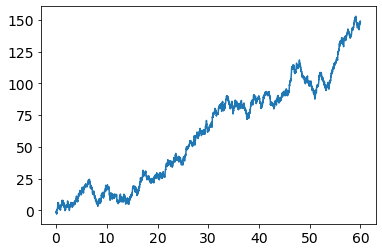

In [145]:
plt.plot(t_t, x_ts[0])

In [146]:
x_spike, theta_spike, t_infield_spike, cell_number = x_theta_t_spike(t_spikes, x_ts, t_t)

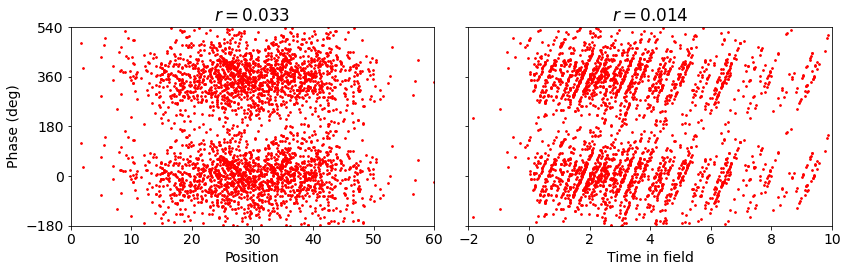

In [149]:
# phase_position_plot(x_spike, theta_spike)
# phase_time_plot(t_infield_spike, theta_spike)
fig = phase_combo_plot(x_spike, t_infield_spike, theta_spike)
fig.savefig('output/brown_correlation.svg', bbox_inches='tight')